<a href="https://colab.research.google.com/github/talhaanwarch/ConvNet-for-EEG-cognitive-task-classification/blob/master/Feature_Selection_Approach_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Packages

In this approach data is segmented and feature are calculated for each segment. Then these features are averaged

In [0]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [0]:
!pip install wfdb
!pip install mne
!pip install nitime

     |████████████████████████████████| 102kB 7.7MB/s 
     |████████████████████████████████| 163kB 36.6MB/s 
  Created wheel for wfdb: filename=wfdb-2.2.1-cp36-none-any.whl size=100368 sha256=1d4b4c331f3a015975ae34543c622925bc9f5848624ddc562efa18f65d14d186
  Stored in directory: /root/.cache/pip/wheels/bb/a9/00/0078d26b0c15b31be0001af8eb659496709c361c69641303f1
Successfully built wfdb
     |████████████████████████████████| 6.4MB 7.1MB/s 
     |████████████████████████████████| 9.1MB 7.2MB/s 
  Created wheel for nitime: filename=nitime-0.8.1-cp36-cp36m-linux_x86_64.whl size=4038232 sha256=f20a5d6e4efa935d65c403c01c428189eaf9fcfd822fd6457aa5646b6e9620a9
  Stored in directory: /root/.cache/pip/wheels/74/02/c5/677c895b41dcaf4fd7c4ff436fbdf8a5d846ed90a0a3276073
Successfully built nitime


In [0]:
!pip install git+https://github.com/forrestbao/pyeeg.git
!pip install git+https://github.com/raphaelvallat/entropy.git

  Cloning https://github.com/forrestbao/pyeeg.git to /tmp/pip-req-build-1l6yhg0f
  Running command git clone -q https://github.com/forrestbao/pyeeg.git /tmp/pip-req-build-1l6yhg0f
  Created wheel for pyeeg: filename=pyeeg-0.4.4-py2.py3-none-any.whl size=28121 sha256=4c4f4ae0bdd9ad906d64785fcef962fb2faee4ba0466bdda438a40b7a5f4bee1
  Stored in directory: /tmp/pip-ephem-wheel-cache-pkaqdx6u/wheels/2d/3f/ad/106d4fc80b61d1ea1fc18e76e7439fd98aa043d83d58eae741
Successfully built pyeeg
  Cloning https://github.com/raphaelvallat/entropy.git to /tmp/pip-req-build-hr9prixz
  Running command git clone -q https://github.com/raphaelvallat/entropy.git /tmp/pip-req-build-hr9prixz
  Created wheel for entropy: filename=entropy-0.1.0-cp36-none-any.whl size=14098 sha256=9093a0b1d15320ad149de546d5b31a0c8922fadfdea096c89dbcecdc96808b61
  Stored in directory: /tmp/pip-ephem-wheel-cache-0leh0j0y/wheels/60/ed/d3/b715e38438f1f39edb1383aea79c578073953b25fa576fc71e
Successfully built entropy


# Download data

In [0]:
import wfdb
dbs = wfdb.get_dbs()
wfdb.dl_database('eegmat','data')

Created local base download directory: data
Finished downloading files


# Read data

In [0]:
import glob
import os
import mne
import re
import numpy as np
from sklearn.preprocessing import MaxAbsScaler

/usr/local/lib/python3.6/dist-packages/numba/decorators.py:146: RuntimeWarning: Caching is not available when the 'parallel' target is in use. Caching is now being disabled to allow execution to continue.
  warnings.warn(msg, RuntimeWarning)


In [0]:

path = r'data/' # use your path
all_files = glob.glob(os.path.join(path, "*.edf")) 

i=0
j=0
subject_1=[]
subject_2=[]

for filename in (all_files):
    if int(re.findall(r'\d+',filename)[1])==1:
        data=mne.io.read_raw_edf(filename,preload=True).get_data()[0:-3,10000:40000].T
        subject_1.append(data)
    else:
        data=mne.io.read_raw_edf(filename,preload=True).get_data()[0:-3,0:30000].T
        subject_2.append(data)        

Extracting EDF parameters from /content/data/Subject35_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Extracting EDF parameters from /content/data/Subject11_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...
Extracting EDF parameters from /content/data/Subject20_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Extracting EDF parameters from /content/data/Subject06_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Extracting EDF parameters from /content/data/Subject28_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   1

# Feature Extraction

In [0]:
from scipy import stats
import pyeeg
from entropy import *
import pywt
from nitime import algorithms as alg


In [0]:
def mean(data):
    return np.mean(data,axis=0)
    
def std(data):
    return np.std(data,axis=0)

def ptp(data):
    return np.ptp(data,axis=0)

def var(data):
        return np.var(data,axis=0)

def skewness(data):
    return stats.skew(data,axis=0)

def kurtosis(data):
    return stats.kurtosis(data,axis=0)

def app_epy(data):
    result=[]
    for i in data.T:
        result.append(app_entropy(i, order=2, metric='chebyshev'))
    return np.array(result)

def perm_epy(data):
    result=[]
    for i in data.T:
        result.append(perm_entropy(i, order=3, normalize=True))
    return np.array(result)

def svd_epy(data):
    result=[]
    for i in data.T:
        result.append(svd_entropy(i, order=3, delay=1, normalize=True))
    return np.array(result)

def spectral_epy(data):
    result=[]
    for i in data.T:
        result.append(spectral_entropy(i, 100, method='welch', normalize=True))
    return np.array(result)

def sample_epy(data):
    result=[]
    for i in data.T:
        result.append(sample_entropy(i, order=2, metric='chebyshev'))
    return np.array(result)


def katz(data):
    result=[]
    for i in data.T:
        result.append(katz_fd(i))
    return np.array(result)

def higuchi(data):
    result=[]
    for i in data.T:
        result.append(higuchi_fd(i))
    return np.array(result)


def petrosian(data):
    result=[]
    for i in data.T:
        result.append(petrosian_fd(i))
    return np.array(result)

def autogressiveModelParameters(data):
    feature = []
    for i in data.T:
        coeff, sig = alg.AR_est_YW(i, order=5)
        feature.append(np.mean(coeff))
    return np.array(feature)

def teager(x):
    for i in range(len(x)-1):
        return x[i]**2 - (x[i-1]*x[i+1])

def wavelet_features(data):
    dwt={}
    for i in range(18):
        dwt[i]=pywt.wavedec(data.T[i],"db1", level=4)
    mean=[]
    tkeo=[]
    for i in dwt.values():
        for j in range(5):
            mean.append(i[j].mean())
            tkeo.append(teager(i[j]))
    return np.array(tkeo),np.array(mean)

def dwt_mean(data):
    _,mean= wavelet_features(data)
    return mean
    
def dwt_tkeo(data):
    tkeo,_= wavelet_features(data) 
    return tkeo
        

def concatenate(data):
    return np.concatenate((mean(data),std(data),ptp(data),var(data),skewness(data),kurtosis(data),
                           app_epy(data),perm_epy(data),svd_epy(data),spectral_epy(data),sample_epy(data),
                           katz(data),higuchi(data),petrosian(data),autogressiveModelParameters(data),dwt_mean(data),
                           dwt_tkeo(data)),axis=0)


In [0]:
features1=[]
for f in subject_1:
    feature=[]
    b=f.reshape(-1,3000,18)
    for i in b:
        feature.append(concatenate(i))
    features1.append((np.array(feature)))

In [0]:
features2=[]
for f in subject_2:
    feature=[]
    b=f.reshape(-1,3000,18)
    for i in b:
        feature.append(concatenate(i))
    features2.append((np.array(feature)))

In [0]:
len(features1),len(features2)

(36, 36)

In [0]:
features1[0].shape,features1[1].shape

((10, 450), (10, 450))

In [0]:
x1=np.array(features1)        
x2=np.array(features2)      

X=np.concatenate((x1,x2),axis=0)

y=np.concatenate(((np.zeros(x1.shape[0])),(np.ones(x2.shape[0]))))

In [0]:
X.shape,y.shape

((72, 10, 450), (72,))

# Classification

In [0]:
import numpy as np 
from sklearn.model_selection import ShuffleSplit # or StratifiedShuffleSplit
sss = ShuffleSplit(n_splits=1, test_size=0.2)
sss.get_n_splits(X, y)
train_index, test_index = next(sss.split(X, y)) 

X_train, X_test = X[train_index], X[test_index] 
y_train, y_test = y[train_index], y[test_index]

In [0]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((57, 10, 450), (15, 10, 450), (57,), (15,))

In [0]:
y_test

array([0., 0., 1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 0., 1., 1.])

In [0]:
y_train = np.array( [ele for ele in y_train for i in range(10)] )
y_test =np.array([ele for ele in y_test for i in range(10)] )  


In [0]:
X_train=X_train.reshape(-1,450)
X_test=X_test.reshape(-1,450)

In [0]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((570, 450), (150, 450), (570,), (150,))

In [0]:
from sklearn.neighbors import KNeighborsClassifier
clf=KNeighborsClassifier(3)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

from sklearn.metrics import classification_report,accuracy_score
print(classification_report(y_test,y_pred))
print('accuracy is ',accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.49      0.70      0.58        60
         1.0       0.72      0.52      0.61        90

    accuracy                           0.59       150
   macro avg       0.61      0.61      0.59       150
weighted avg       0.63      0.59      0.60       150

accuracy is  0.5933333333333334


# Cross Validation

In [0]:
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
import pandas as pd
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler


In [0]:
classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="rbf"),
    NuSVC(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    LogisticRegression()]


In [0]:

skf = StratifiedKFold(n_splits=5)
skf.get_n_splits(X, y)

acc=[]
for train_index, test_index in skf.split(X, y):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    X_train=X_train.reshape(-1,450)
    X_test=X_test.reshape(-1,450)

    y_train = np.array( [ele for ele in y_train for i in range(10)] )
    y_test =np.array([ele for ele in y_test for i in range(10)] )  



    scaler = StandardScaler()
    X_train=scaler.fit_transform(X_train)
    X_test=scaler.transform(X_test)
    
    
    clf = SVC(kernel="rbf")
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    accuracy=accuracy_score(y_test, y_pred)
    print(accuracy)
    acc.append(accuracy)
    
print('-------------------------')    
print('mean',np.array(acc).mean())    
print('std',np.array(acc).std())

0.49375
0.6142857142857143
0.5357142857142857
0.65
0.5857142857142857
-------------------------
mean 0.5758928571428571
std 0.0555411687721048


In [0]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

raw_acc=[]
skf = StratifiedKFold(n_splits=5)
skf.get_n_splits(X, y)
for clf in classifiers:
    name = clf.__class__.__name__
    clf_acc=[]

    print("="*30)
    print(name)       
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        X_train=X_train.reshape(-1,450)
        X_test=X_test.reshape(-1,450)

        y_train = np.array( [ele for ele in y_train for i in range(10)] )
        y_test =np.array([ele for ele in y_test for i in range(10)] )  

        scaler = StandardScaler()
        X_train=scaler.fit_transform(X_train)
        X_test=scaler.transform(X_test)

        clf.fit(X_train,y_train)
        y_pred = clf.predict(X_test)
        accuracy=accuracy_score(y_test, y_pred)
        clf_acc.append(accuracy)
    print('mean',np.array(clf_acc).mean())    
    raw_acc.append(np.array(clf_acc).mean())
    
    

KNeighborsClassifier
mean 0.5566071428571429
SVC
mean 0.5758928571428571
NuSVC
mean 0.5599999999999999
DecisionTreeClassifier
mean 0.5383928571428571
RandomForestClassifier
mean 0.5683928571428571
AdaBoostClassifier
mean 0.614107142857143
GradientBoostingClassifier
mean 0.6139285714285715
GaussianNB
mean 0.5907142857142857
LinearDiscriminantAnalysis
mean 0.5069642857142858
QuadraticDiscriminantAnalysis


/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


mean 0.48964285714285716
LogisticRegression
mean 0.5360714285714285


In [0]:
raw_acc

[0.5566071428571429,
 0.5758928571428571,
 0.5599999999999999,
 0.5398214285714286,
 0.5366071428571428,
 0.614107142857143,
 0.6125,
 0.5907142857142857,
 0.5069642857142858,
 0.48964285714285716,
 0.5360714285714285]

Text(0.5, 1.0, 'Classifiers')

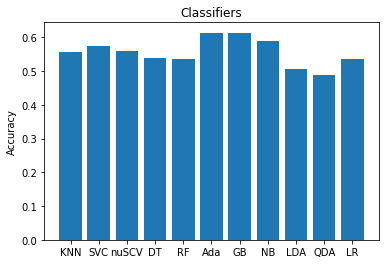

In [0]:
import matplotlib.pyplot as plt
classifier=['KNN','SVC','nuSCV','DT','RF','Ada','GB','NB','LDA','QDA','LR']
y_pos = np.arange(len(classifier))
plt.bar(y_pos,np.array(raw_acc))
plt.xticks(y_pos, classifier)
plt.ylabel('Accuracy')
plt.title('Classifiers')

# Principle Component Analysis

In [0]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.decomposition import KernelPCA
from sklearn.model_selection import cross_val_score

#Fitting the PCA algorithm with our Data
pca = PCA().fit(X)
#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('EEG')
plt.show()

ValueError: ignored

In [0]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
scalar = StandardScaler()
clf = SVC(kernel='rbf')
pca = PCA(n_components=20)

pipeline = Pipeline([('selector',pca), ('estimator', clf)])
#pipeline = Pipeline([('transformer', scalar),('selector',rfe), ('estimator', clf)])


In [0]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

pca_acc=[]
skf = StratifiedKFold(n_splits=5)
skf.get_n_splits(X, y)
for clf in classifiers:
    name = clf.__class__.__name__
    clf_acc=[]

    print("="*30)
    print(name)       
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        X_train=X_train.reshape(-1,450)
        X_test=X_test.reshape(-1,450)

        y_train = np.array( [ele for ele in y_train for i in range(10)] )
        y_test =np.array([ele for ele in y_test for i in range(10)] )  
# Apply standard scaler
        scaler = StandardScaler()
        X_train=scaler.fit_transform(X_train)
        X_test=scaler.transform(X_test)
#Apply PCA
        pca = PCA(n_components=20)
        X_train=pca.fit_transform(X_train)
        X_test=pca.transform(X_test)
#Apply classification
        clf.fit(X_train,y_train)
        y_pred = clf.predict(X_test)
        accuracy=accuracy_score(y_test, y_pred)
        clf_acc.append(accuracy)
    print('mean',np.array(clf_acc).mean())    
    pca_acc.append(np.array(clf_acc).mean())
    

KNeighborsClassifier
mean 0.573392857142857
SVC
mean 0.5294642857142857
NuSVC
mean 0.5421428571428571
DecisionTreeClassifier
mean 0.5594642857142856
RandomForestClassifier
mean 0.6007142857142858
AdaBoostClassifier
mean 0.6094642857142858
GradientBoostingClassifier
mean 0.5878571428571429
GaussianNB
mean 0.6328571428571428
LinearDiscriminantAnalysis
mean 0.6483928571428571
QuadraticDiscriminantAnalysis
mean 0.57125
LogisticRegression
mean 0.6460714285714285


# RFE

In [0]:
from sklearn.preprocessing import MaxAbsScaler,StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE


In [0]:
classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="rbf"),
    NuSVC(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    LogisticRegression()]


In [0]:

clf = SVC(kernel='rbf')
rfe=RFE(SVC(kernel='linear'),n_features_to_select=50,step=10,verbose=0)   




In [0]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

rfe_acc=[]
skf = StratifiedKFold(n_splits=5)
skf.get_n_splits(X, y)
for clf in classifiers:
    name = clf.__class__.__name__
    clf_acc=[]

    print("="*30)
    print(name)       
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        X_train=X_train.reshape(-1,450)
        X_test=X_test.reshape(-1,450)

        y_train = np.array( [ele for ele in y_train for i in range(10)] )
        y_test =np.array([ele for ele in y_test for i in range(10)] )  
# Apply standard scaler
        scaler = StandardScaler()
        X_train=scaler.fit_transform(X_train)
        X_test=scaler.transform(X_test)
#Apply RFE
        X_train=rfe.fit_transform(X_train,y_train)
        X_test=rfe.transform(X_test)
#Apply classification
        clf.fit(X_train,y_train)
        y_pred = clf.predict(X_test)
        accuracy=accuracy_score(y_test, y_pred)
        clf_acc.append(accuracy)
    print('mean',np.array(clf_acc).mean())    
    rfe_acc.append(np.array(clf_acc).mean())
    

KNeighborsClassifier
mean 0.48464285714285715
SVC
mean 0.5235714285714286
NuSVC
mean 0.5176785714285714
DecisionTreeClassifier
mean 0.5183928571428572
RandomForestClassifier
mean 0.5839285714285715
AdaBoostClassifier
mean 0.5626785714285714
GradientBoostingClassifier
mean 0.5621428571428572
GaussianNB
mean 0.5871428571428571
LinearDiscriminantAnalysis
mean 0.49607142857142855
QuadraticDiscriminantAnalysis
mean 0.41785714285714287
LogisticRegression
mean 0.5314285714285714


# SKbest

In [0]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif


In [0]:

scalar = StandardScaler()
clf = SVC(kernel='rbf')
skbest=SelectKBest(f_classif, k=20)


In [0]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

skbest_acc=[]
skf = StratifiedKFold(n_splits=5)
skf.get_n_splits(X, y)
for clf in classifiers:
    name = clf.__class__.__name__
    clf_acc=[]

    print("="*30)
    print(name)       
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        X_train=X_train.reshape(-1,450)
        X_test=X_test.reshape(-1,450)

        y_train = np.array( [ele for ele in y_train for i in range(10)] )
        y_test =np.array([ele for ele in y_test for i in range(10)] )  
# Apply standard scaler
        scaler = StandardScaler()
        X_train=scaler.fit_transform(X_train)
        X_test=scaler.transform(X_test)
#Apply Skbest
        X_train=skbest.fit_transform(X_train,y_train)
        X_test=skbest.transform(X_test)
#Apply classification
        clf.fit(X_train,y_train)
        y_pred = clf.predict(X_test)
        accuracy=accuracy_score(y_test, y_pred)
        clf_acc.append(accuracy)
    print('mean',np.array(clf_acc).mean())    
    skbest_acc.append(np.array(clf_acc).mean())
    

KNeighborsClassifier
mean 0.5014285714285714
SVC
mean 0.5323214285714286
NuSVC
mean 0.5221428571428571
DecisionTreeClassifier
mean 0.5123214285714286
RandomForestClassifier
mean 0.5451785714285714
AdaBoostClassifier
mean 0.5253571428571429
GradientBoostingClassifier
mean 0.5342857142857144
GaussianNB
mean 0.5310714285714285
LinearDiscriminantAnalysis
mean 0.5458928571428572
QuadraticDiscriminantAnalysis
mean 0.4367857142857143
LogisticRegression
mean 0.5432142857142858


# VarianceThreshold

In [0]:
from sklearn.feature_selection import VarianceThreshold
scalar = StandardScaler()
clf = SVC(kernel='rbf')
algo=selector = VarianceThreshold()
pipeline = Pipeline([('selector',algo), ('estimator', clf)])
#pipeline = Pipeline([('transformer', scalar),('selector',rfe), ('estimator', clf)])


In [0]:

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

accuracy_var=[]
std_var=[]
f1_scores=[]
f1_scores_std=[]
for clfs in classifiers:
    pipeline.set_params(estimator = clfs)
    name = clfs.__class__.__name__
    
    print("="*30)
    print(name)       
    print('****Results****')
    scores = cross_val_score(pipeline, X, y, cv=5)
    #f1_score = cross_val_score(clf, X_rfe, y, cv=5,scoring='f1')
    print("Accuracy: {:.4%}".format(np.array(scores).mean()))
    accuracy_var.append(np.array(scores).mean())
    std_var.append(np.array(scores).std())
    #f1_scores.append(np.array(f1_score).mean())
    #f1_scores_std.append(np.array(f1_score).std())


KNeighborsClassifier
****Results****
Accuracy: 72.3214%
SVC
****Results****
Accuracy: 63.9286%
NuSVC
****Results****
Accuracy: 70.7143%
DecisionTreeClassifier
****Results****
Accuracy: 50.8929%
RandomForestClassifier
****Results****
Accuracy: 56.7857%
AdaBoostClassifier
****Results****
Accuracy: 61.2500%
GradientBoostingClassifier
****Results****
Accuracy: 57.3214%
GaussianNB
****Results****
Accuracy: 62.1429%
LinearDiscriminantAnalysis
****Results****
Accuracy: 75.0000%
QuadraticDiscriminantAnalysis
****Results****
Accuracy: 43.0357%
LogisticRegression
****Results****
Accuracy: 70.8929%


/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.6/dist-packages/sklearn/d

In [0]:
len(accuracy),len(accuracy_pca),len(accuracy_rfe),len(accuracy_kbest),len(accuracy_var)

(11, 11, 11, 27, 11)

In [0]:
result=pd.DataFrame([accuracy,accuracy_pca,accuracy_rfe,accuracy_kbest,accuracy_var],
                    index=['Accuracy','PCA',"RFE",'kbest','VAR'],
                    columns=['KNN','SVC','nuSCV','DT','RF','Ada','GB','NB','LDA','QDA','LR'])

In [0]:
result.T

,Accuracy,PCA,RFE,kbest,VAR
KNN,0.723214,0.723214,0.614286,0.723214,0.723214
SVC,0.639286,0.667857,0.680357,0.639286,0.639286
nuSCV,0.707143,0.721429,0.794643,0.707143,0.707143
DT,0.537500,0.664286,0.496429,0.567857,0.508929
RF,0.621429,0.564286,0.707143,0.567857,0.567857
Ada,0.612500,0.623214,0.582143,0.612500,0.612500
GB,0.625000,0.651786,0.619643,0.637500,0.573214
NB,0.621429,0.664286,0.664286,0.621429,0.621429
LDA,0.750000,0.733929,0.651786,0.750000,0.750000
QDA,0.430357,0.607143,0.541071,0.430357,0.430357
